In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
project_path = "/content/drive/MyDrive/U-Net"
os.chdir(project_path)
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/U-Net


In [4]:
!pip install -q segmentation-models-pytorch
!pip install -q --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00


In [1]:
import cv2
import torch
import wandb
import itertools
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from wandb import Api
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [6]:
wandb.login() # use your own key

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mkwambetumelo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(output_channels, output_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, feature_bank):
        feature_bank = self.block(feature_bank)
        return feature_bank

In [3]:
class Decoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(output_channels, output_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, decoder_feature_bank, encoder_feature_bank):
        '''
        if decoder_feature_bank.shape[2:] != encoder_feature_bank.shape[2:]:
            decoder_feature_bank = F.interpolate(
                decoder_feature_bank,
                size=encoder_feature_bank.shape[2:],
                mode='bilinear',
                align_corners=False
            )
        '''

        feature_bank = torch.cat([decoder_feature_bank, encoder_feature_bank], dim = 1)
        feature_bank = self.block(feature_bank)
        return feature_bank

In [4]:
import time

In [5]:
class U_Net(nn.Module):
    def __init__(self):
        super().__init__()
        channels = [3, 64, 128, 256, 512, 1024]
        self.encoder = nn.ModuleList([
            Encoder(channels[i], channels[i + 1]) for i in range(len(channels) - 1)
        ])
        channels.reverse()
        self.decoder = nn.ModuleList([
            Decoder(channels[i], channels[i + 1]) for i in range(len(channels) - 2)
        ])

        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.convUps = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size = 2, stride = 2) for i in range(len(channels) - 2)
        ])

        self.final_conv = nn.Conv2d(64, 2, kernel_size = 3, padding = 1)


    def forward(self, img):

        encoder_feature_banks = []
        feature_bank = img
        t = time.time()
        for idx, block in enumerate(self.encoder):
            feature_bank = block(feature_bank)

            if idx < len(self.encoder) - 1:
                encoder_feature_banks.append(feature_bank)
                feature_bank = self.max_pool(feature_bank)
        print(f'Encoder Duration: {time.time() - t}')
        encoder_feature_banks.reverse()

        t = time.time()
        for idx, block in enumerate(self.decoder):
            feature_bank = self.convUps[idx](feature_bank)
            feature_bank = block(feature_bank, encoder_feature_banks[idx])
        print(f'Decoder Duration: {time.time() - t}')
        output = self.final_conv(feature_bank)

        return output

In [12]:
class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, mask = self.data[idx]
        return image, mask

In [6]:
def retrieve_data(type_, img_nums):
    data = []

    for img_num in img_nums:
        img_label = cv2.imread(f'./images-1024x768/{type_}/image-{img_num}.png')
        img_target = cv2.imread(f'./masks-1024x768/{type_}/mask-{img_num}.png', cv2.IMREAD_GRAYSCALE)
        foreground = (img_target > 0).astype(np.float32)
        background = 1.0 - foreground
        img_target = np.stack([background, foreground], axis = 0)
        data.append([img_label, img_target])

    return data

train_data = retrieve_data('train', [2, 7, 10, 12, 21, 24, 27, 28, 30, 43])
val_data = retrieve_data('val', [1, 11, 22, 32])
test_data = retrieve_data('test', [4, 16, 29, 36])

In [7]:
u = U_Net()
image = np.transpose(train_data[0][0], (2, 0, 1))
img = torch.tensor([image], dtype = torch.float32) ; img.shape

/tmp/ipykernel_51218/4188508711.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  img = torch.tensor([image], dtype = torch.float32) ; img.shape


torch.Size([1, 3, 768, 1024])

In [ ]:
u(img)

Encoder Duration: 3.705836534500122


In [14]:
def preprocess_img(img):
    image_tensor = torch.tensor(img, dtype = torch.float32)
    image_tensor = image_tensor.permute(2, 0, 1)
    return image_tensor / 255.0

def preprocess_mask(img):
    image_tensor = torch.tensor(img, dtype = torch.float32)
    return image_tensor

train_data = [[preprocess_img(entry[0]), preprocess_mask(entry[1])] for entry in train_data]
val_data = [[preprocess_img(entry[0]), preprocess_mask(entry[1])] for entry in val_data]
test_data = [[preprocess_img(entry[0]), preprocess_mask(entry[1])] for entry in test_data]

In [15]:
def metrics(true_masks, predictions):

    predictions = np.concatenate(predictions).flatten()
    true_masks = np.concatenate(true_masks).flatten()

    accuracy = accuracy_score(true_masks, predictions)
    precision = precision_score(true_masks, predictions, zero_division = 0, average = 'macro')
    recall = recall_score(true_masks, predictions, zero_division = 0, average = 'macro')
    f1 = f1_score(true_masks, predictions, zero_division = 0, average = 'macro')

    iou = []
    num_classes = 2
    for i in range(num_classes):
        intersection = np.sum((true_masks == i) & (predictions == i))
        union = np.sum((true_masks == i) | (predictions == i))
        iou.append(intersection / union if union != 0 else 0)

    return accuracy, precision, recall, f1, np.mean(iou)

In [16]:
def nontraining_loop(type_, model, data, batch_size = 1, device="cuda"):

    dataset = ImageDataset(data)
    dataloader = DataLoader(dataset, batch_size, shuffle=False)

    loss_function = nn.CrossEntropyLoss()
    total_loss = 0.0

    predictions = []
    true_masks = []

    model.eval()
    with torch.no_grad():
        for image, mask in dataloader:
            image = image.to(device)
            mask = mask.to(device)

            logits = model(image)
            loss = loss_function(logits, torch.argmax(mask, dim = 1))
            total_loss += loss.item()

            prediction = torch.argmax(logits, dim=1)
            true_mask = torch.argmax(mask, dim=1)

            predictions.append(prediction.cpu().numpy())
            true_masks.append(true_mask.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy, precision, recall, f1, iou = metrics(true_masks, predictions)

    wandb.log({
          f"{type_} Loss": avg_loss,
          f"{type_} IoU": iou
    })

    print(f"{type_} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision} | Recall: {recall} | F1 Score: {f1} | IoU: {iou}  \n")

    return avg_loss, accuracy, precision, f1, iou


In [17]:
def training_loop(model, train_data, val_data, num_epochs = 10, batch_size = 1, learning_rate = 1e-3, device = "cuda"):

    train_dataset = ImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)

    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model.train()
    for epoch in range(num_epochs):
        predictions = []
        true_masks = []
        total_loss = 0.0
        for image, mask in train_dataloader:
            image = image.to(device)
            mask = mask.to(device)
            optimizer.zero_grad()
            logits = model(image)
            loss = loss_function(logits, torch.argmax(mask, dim = 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            prediction = torch.argmax(logits, dim=1)
            true_mask = torch.argmax(mask, dim=1)

            predictions.append(prediction.cpu().numpy())
            true_masks.append(true_mask.cpu().numpy())

        train_loss = total_loss / len(train_dataloader)
        accuracy, precision, recall, f1, iou = metrics(true_masks, predictions)

        wandb.log({
              f"Training Loss": train_loss,
              f"Training IoU": iou
        })


        print(f"Epoch: {epoch} | Training | Loss: {train_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision} | Recall: {recall} | F1 Score: {f1} | IoU: {iou}")
        val_loss = nontraining_loop("Validation", model, val_data, 1, device)

    return model, iou

In [18]:
def find_best_hyperparameters():

    num_epochs = [10]
    batch_size = [1, 2, 3, 4]
    learning_rate = [1e-2, 1e-3, 1e-4]

    best_model = None
    best_iou = 0

    for idx, combination in enumerate(list(itertools.product(num_epochs, batch_size, learning_rate))):

        wandb.init(entity = "computer-vision-wits", project = "computer-vision-wits", name = f"run_{idx}")

        config = wandb.config
        config.epochs = combination[0]
        config.batch_size = combination[1]
        config.learning_rate = combination[2]

        model, iou = training_loop(
            train_data,
            val_data,
            num_epochs = combination[0],
            batch_size = combination[1],
            learning_rate = combination[2],
            device = "cuda"
        )

        if iou > best_iou:
          best_iou = iou
          best_model = model

        wandb.finish()

    return model

In [20]:
# best hyperparameters: {learning rate: }, {batch_size: }

wandb.init(entity = "computer-vision-wits", project = "computer-vision-wits", name = f"u-run")

model = U_Net()
training_loop(model, train_data, val_data, num_epochs = 10, batch_size = 2, learning_rate = 1e-3, device = device)
torch.cuda.empty_cache()

wandb.finish()

Epoch: 0 | Training | Loss: 0.8504 | Accuracy: 0.6489 | Precision: 0.49627341433049577 | Recall: 0.4968010342977962 | F1 Score: 0.49492576539243055 | IoU: 0.37609335066850275
Validation | Loss: 0.4861 | Accuracy: 0.7605 | Precision: 0.38025252024332684 | Recall: 0.5 | F1 Score: 0.43198117755824683 | IoU: 0.38025252024332684  

Epoch: 1 | Training | Loss: 0.5764 | Accuracy: 0.7522 | Precision: 0.3761050542195638 | Recall: 0.5 | F1 Score: 0.4292921863743829 | IoU: 0.3761050542195638
Validation | Loss: 0.5677 | Accuracy: 0.7605 | Precision: 0.38025252024332684 | Recall: 0.5 | F1 Score: 0.43198117755824683 | IoU: 0.38025252024332684  

Epoch: 2 | Training | Loss: 0.7693 | Accuracy: 0.7522 | Precision: 0.3761050542195638 | Recall: 0.5 | F1 Score: 0.4292921863743829 | IoU: 0.3761050542195638
Validation | Loss: 0.5820 | Accuracy: 0.7605 | Precision: 0.38025252024332684 | Recall: 0.5 | F1 Score: 0.43198117755824683 | IoU: 0.38025252024332684  

Epoch: 3 | Training | Loss: 0.6253 | Accuracy: 0.

Training IoU,▁▁▁▁▂▂▃▅▅█
Training Loss,█▄▇▅▅▄▃▃▂▁
Validation IoU,▁▁▁▁▃▂▄▇██
Validation Loss,▆▇██▇▅▄▃▂▁
Training IoU,0.74322
Training Loss,0.36232
Validation IoU,0.9179
Validation Loss,0.16283


In [21]:
def display_plots(metric):
    train_df = history.dropna(subset=[f"Training {metric}"])
    val_df   = history.dropna(subset=[f"Validation {metric}"])

    plt.figure(figsize=(8,5))
    plt.plot(train_df["_step"], train_df[f"Training {metric}"], label=f"Training {metric}")
    plt.plot(val_df["_step"], val_df[f"Validation {metric}"], label=f"Validation {metric}")
    plt.legend()
    plt.show()

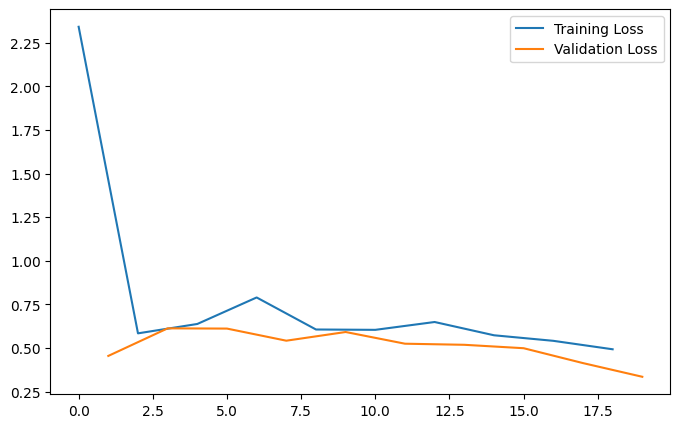

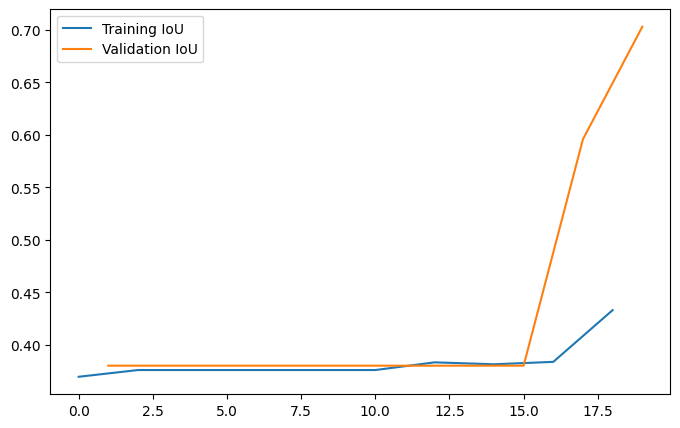

In [23]:
api = Api()
run = api.run("computer-vision-wits/computer-vision-wits/cxtjnrfs")
history = run.history()

display_plots("Loss")
display_plots("IoU")

In [ ]:
'''
Based on the graphs and the provided metrics, the model is not overfitting.
Both the training and validation curves indicate that the model is still learning and improving.
A sign of overfitting is when the training loss continues to decrease, but the validation loss begins to increase.
In the above graphs, both training and validation loss are decreasing, which suggests the model is still improving on unseen data.

If the model were overfitting, we would implement early stoppage and halt the training process provided that the training loss decreases but the validation loss stays constant.
'''

In [24]:
wandb.init(entity = "computer-vision-wits", project = "U-Net", name = f"u-net-base-testing")

nontraining_loop(
    "Testing",
    model = model,
    data = test_data,
    batch_size = 4,
    device = device
)

wandb.finish()

Testing | Loss: 0.2155 | Accuracy: 0.9415 | Precision: 0.9483961127725646 | Recall: 0.8963798043776364 | F1 Score: 0.9185700557885682 | IoU: 0.8523601100041411  



Testing IoU,▁
Testing Loss,▁
Testing IoU,0.85236
Testing Loss,0.2155


In [25]:
'''
VARIANTS: ResNet
'''

eff_model = smp.Unet(encoder_name="efficientnet-b0", encoder_weights = "imagenet", in_channels = 3, classes = 2)

wandb.init(entity = "computer-vision-wits", project = "computer-vision-wits", name = f"eff")

training_loop(eff_model, train_data, val_data, num_epochs = 10, batch_size = 2, learning_rate = 0.001, device = device)
torch.cuda.empty_cache()

wandb.finish()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch: 0 | Training | Loss: 0.5801 | Accuracy: 0.7362 | Precision: 0.6741824774862925 | Recall: 0.7105580923628063 | F1 Score: 0.6831479575727921 | IoU: 0.5336500136008657
Validation | Loss: 6.9825 | Accuracy: 0.2405 | Precision: 0.6198651070866829 | Recall: 0.5006451836735718 | F1 Score: 0.1946615943146106 | IoU: 0.12051029076025459  

Epoch: 1 | Training | Loss: 2.0355 | Accuracy: 0.3472 | Precision: 0.5071925748142657 | Recall: 0.5059014181415149 | F1 Score: 0.344935630968632 | IoU: 0.20907936630562263
Validation | Loss: 0.5167 | Accuracy: 0.7587 | Precision: 0.38012318552308644 | Recall: 0.49881019842757024 | F1 Score: 0.4313977543148275 | IoU: 0.37934794470723854  

Epoch: 2 | Training | Loss: 0.5584 | Accuracy: 0.7510 | Precision: 0.3760087163732871 | Recall: 0.4992005941284217 | F1 Score: 0.42890062374393834 | IoU: 0.3755038431285622
Validation | Loss: 0.4970 | Accuracy: 0.7595 | Precision: 0.3801363804141688 | Recall: 0.4993629673349379 | F1 Score: 0.4316683836125674 | IoU: 0.3

Training IoU,▅▁▃▃▃▇▇▆█▇
Training Loss,▂█▂▂▂▁▂▂▁▂
Validation IoU,▁▄▄▄▄██▇▇█
Validation Loss,█▁▁▁▁▁▁▁▁▁
Training IoU,0.69921
Training Loss,0.36462
Validation IoU,0.8408
Validation Loss,0.22675


In [28]:
res_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=2)

wandb.init(entity = "computer-vision-wits", project = "computer-vision-wits", name = f"res")

training_loop(res_model, train_data, val_data, num_epochs = 5, batch_size = 2, learning_rate = 0.001, device = device)
torch.cuda.empty_cache()

wandb.finish()

Training IoU,▁
Training Loss,▁
Validation IoU,▁
Validation Loss,▁
Training IoU,0.53878
Training Loss,0.58427
Validation IoU,0.1216
Validation Loss,10.89497


Epoch: 0 | Training | Loss: 0.4610 | Accuracy: 0.8157 | Precision: 0.75466312340264 | Recall: 0.7810326590751733 | F1 Score: 0.7655004627159429 | IoU: 0.6327029185888922
Validation | Loss: 30.4600 | Accuracy: 0.2408 | Precision: 0.6199040240691032 | Recall: 0.5008583638961319 | F1 Score: 0.1951373148377268 | IoU: 0.12076238796523509  

Epoch: 1 | Training | Loss: 8.6837 | Accuracy: 0.5373 | Precision: 0.48844441464353794 | Recall: 0.485072345634989 | F1 Score: 0.4734529919652828 | IoU: 0.32932445303885527
Validation | Loss: 0.9369 | Accuracy: 0.7560 | Precision: 0.37970959882230093 | Recall: 0.49703261490205 | F1 Score: 0.4305211996222939 | IoU: 0.3779958089192708  

Epoch: 2 | Training | Loss: 1.1924 | Accuracy: 0.7496 | Precision: 0.37577808460889234 | Recall: 0.4982503950134736 | F1 Score: 0.428433588742286 | IoU: 0.3747889836629232
Validation | Loss: 0.5366 | Accuracy: 0.7570 | Precision: 0.3798345022066904 | Recall: 0.4977129106122787 | F1 Score: 0.430856573406039 | IoU: 0.3785131

Training IoU,█▁▂▂▂
Training Loss,▁█▂▁▁
Validation IoU,▁████
Validation Loss,█▁▁▁▂
Training IoU,0.37106
Training Loss,0.5804
Validation IoU,0.37559
Validation Loss,2.91302
